In [ ]:
import numpy as np
data_matrix_scaled = np.load('data_matrix_scaled.npy')
validation_data_matrix_scaled = np.load('validation_data_matrix_scaled.npy')
test_data_matrix_scaled = np.load('test_data_matrix_scaled.npy')

digits_train = np.load('digits.npy')
digits_test = np.load('digits_test.npy')
digits_validation = np.load('digits_validation.npy')

# ***KNN hyperparameter tuning using custom GridSearch***

This grid search may take up to 10 minutes to run. The following hyperparameters are tested:

- $n_{neighbors} \in \{1,2,…,30\}$
- Norms (metrics) used for distance : {Manhattan, Euclidean, Cosine, Minkowski}
- Weights : {Uniform, inverse distance}
- Number of components $k_c \in \{1,2,\dots,15\}$

In total, this cell fits $30 \times 4 \times 2 \times 15=3600$ KNN models


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

neighbors = range(1,31)   #hyperparameters
metrics = ['euclidean','manhattan','cosine','minkowski']    #hyperparameters
weights = ['uniform','distance']      #hyperparameters
k_c = range(1,16)     #hyperparameters


best_validation_accuracies = []
test_accuracies = []
#digits_validation = np.load('digits_validation.npy')

#custom grid search
for k in k_c:

  #applying PCA to the data
  temporary_model = PCA(n_components=k)
  temp_training_data = temporary_model.fit_transform(data_matrix_scaled)
  temp_validation_data = temporary_model.transform(validation_data_matrix_scaled)


  best_validation_score = 0
  best_params = {}

  #grid search
  for neighbor in neighbors:
    for metric in metrics:
      for weight in weights:

        model = KNeighborsClassifier(n_neighbors=neighbor,weights=weight,metric=metric)

        model.fit(temp_training_data,digits_train)
        validation_predictions = model.predict(temp_validation_data)

        acc_val = accuracy_score(validation_predictions,digits_validation)

        if acc_val>best_validation_score:
          best_validation_score = acc_val
          #print(best_validation_score)
          best_params = {
                    'n_neighbors': neighbor,
                    'weights': weight,
                    'metric': metric,
                    'validation_accuracy':best_validation_score}

  best_validation_accuracies.append(best_params['validation_accuracy']) #for plotting all accuracies
  print(f"############ \n {k} components : BEST PARAMETERS : {best_params} \n ")




############ 
 1 components : BEST PARAMETERS : {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'validation_accuracy': 0.295} 
 
############ 
 2 components : BEST PARAMETERS : {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'manhattan', 'validation_accuracy': 0.36} 
 
############ 
 3 components : BEST PARAMETERS : {'n_neighbors': 23, 'weights': 'uniform', 'metric': 'euclidean', 'validation_accuracy': 0.579} 
 
############ 
 4 components : BEST PARAMETERS : {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'manhattan', 'validation_accuracy': 0.703} 
 
############ 
 5 components : BEST PARAMETERS : {'n_neighbors': 20, 'weights': 'distance', 'metric': 'manhattan', 'validation_accuracy': 0.76} 
 
############ 
 6 components : BEST PARAMETERS : {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean', 'validation_accuracy': 0.815} 
 
############ 
 7 components : BEST PARAMETERS : {'n_neighbors': 15, 'weights': 'distance', 'metric': 'euclidean', 'validatio

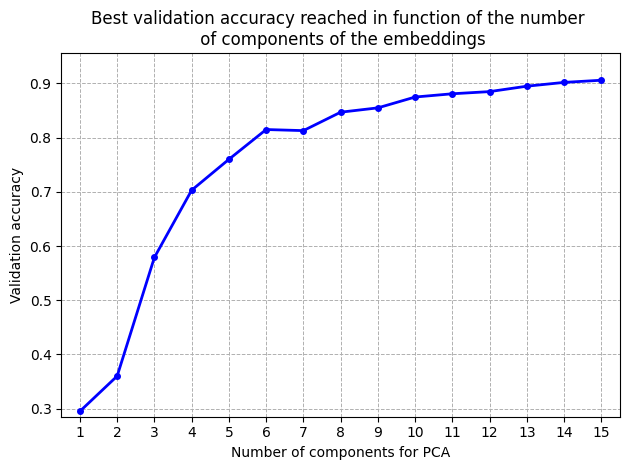

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(best_validation_accuracies)+1),best_validation_accuracies,marker='o', linestyle='-', color='b', linewidth=2, markersize=4)
plt.title("Best validation accuracy reached in function of the number \n of components of the embeddings")
plt.grid(True, which='both', linestyle='--', linewidth=0.7)
plt.xticks(range(1,len(best_validation_accuracies)+1))
plt.xlim([1-0.5, len(best_validation_accuracies)+0.5])
plt.ylim([min(best_validation_accuracies) - 0.01, max(best_validation_accuracies) + 0.05])
plt.xlabel("Number of components for PCA")
plt.ylabel("Validation accuracy")
plt.tight_layout()
plt.show()


# ***Calculating our test accuracy and discussion on the results***

In [ ]:
best_model_pca = PCA(n_components=15)
training_data = best_model_pca.fit_transform(data_matrix_scaled)

#instantiating the model with hyperparameters yielding best validation accuracy
best_model = KNeighborsClassifier(n_neighbors=4,weights='uniform',metric='cosine')
best_model.fit(training_data,digits_train)

#transforming the test data into a 15 dimensional space
testing_data = best_model_pca.transform(test_data_matrix_scaled)

test_predictions = best_model.predict(testing_data)

acc_test = accuracy_score(test_predictions,digits_test)

print("Test accuracy of the best model : ",round(acc_test,3))

Test accuracy of the best model :  0.895


## **Discussion on the results:**

Our final results yield an accuracy of about $89.5 \%$ for the classification of our MNIST digits. To summarize, our way to proceed is the following:



1.   **Transforming the training the data** : we start by performing principal component analysis on our dataset of 6000 images. This roughly consists of projecting these $784$ dimensional obects into a $15$ dimensional space, which happens to reduce the size of our data matrix from $4,704,400$ entries to $90,000$ (~$98 \%$ less).

2.   **Training the KNN model**. We fit our model with the training data and the following hyperparameters : {**$n_{neighbors}$** : $4$, **weights** : uniform , **metric** : cosine}. We showed above that this set of parameters helped us achieve the highest validation accuracy

3. **New data** : suppose we wish to classify another image as a digit. This $1\times784$ array should be projected onto the subspace computed on our training data. Then we feed this transformed array (which is now a $1\times15$ array) into our model. This model has an accuracy of about $89.5 \%$


Note however that classifying MNIST digits is a famous problem and many techniques exist, including ones that perform much better. Traditionally, ML scientist have used convolutional neural networks (CNNs) for image classification, which turn out to produce classifications with much higher accuracies. Indeed, "small" networks can achieve up to $98.4 \%$ accuracy, and most likely even more for deeper networks.
See https://medium.com/analytics-vidhya/get-started-with-your-first-deep-learning-project-7d989cb13ae5
